### This is a turtoial of using the imebuildv2 board (RPi Controller) with python notebook

#### 1 import necessary libraries

In [1]:
import base64
import time
import paramiko

import serial
import numpy as np
from math import log
from math import sqrt
from time import sleep
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm
import scipy.io as sio
from sklearn.linear_model import LinearRegression
import csv

#### 2 define some functions

In [2]:
# send a command and return the controller's response
def write_and_read(shell, cmd):
    shell.send(cmd+"\n")
    count = 0
    nTimeout = 3
    while ( (count<nTimeout) and (not shell.recv_ready()) ):
        time.sleep(1)
    if (count<nTimeout):
        out = shell.recv(999).decode()
        out = out.splitlines()
        out = out[1:len(out)]
        # print("Send:"+cmd+", Receieved:"+out)
        return out
    else:
        print("Error: Time out!")
        return

In [3]:
# flush the ssh terminal
def flush(shell):
    shell.settimeout(3)
    try:
        shell.recv(9999)
    except:
        print("Shell flushed!")

# reset the board (cmd = "*RST")
def reset(shell):
    shell.send('*RST\n')
    while not shell.recv_ready():
        time.sleep(1)
    out = shell.recv(9999)
    print(out.decode())

# query the available slots and channels (cmd = "*OCC?")
def get_occupancy(shell):
    cmd = "*OCC?"
    lines = write_and_read(shell, cmd)
    lines = lines[1:len(lines)]
    occupancy = []
    for slot in range(len(lines)):
        slot_occupancy = lines[slot].rsplit(':')[1]
        occupancy.append(int(slot_occupancy,2))
        if (occupancy[slot]>0):
            print("Slot {}:".format(slot), end=" ")
            for ch in range(8):
                if ( occupancy[slot]&(1<<(7-ch)) ):
                    print("Ch {}: good,".format(ch), end=" ")
                else:
                    print("Ch {}: bad,".format(ch), end=" ")
            print("")
        else:
            print("Slot {} is not used".format(slot))
    occupancy = np.asarray(occupancy)
    return occupancy

RANGE_5V_UNI        =  "5V_UNI"
RANGE_10V_UNI       =  "10V_UNI"
RANGE_5V_BIP        =  "5V_BIP"
RANGE_10V_BIP       =  "10V_BIP"
RANGE_20mA_UNI      =  "20mA_UNI"
RANGE_24mA_UNI      =  "24mA_UNI"
RANGE_4_24mA        =  "4_24mA"
RANGE_20mA_BIP      =  "20mA_BIP"
RANGE_24mA_BIP      =  "24mA_BIP"
RANGE_22mA_OVR      =  "22mA_OVR"

# set the output range of a designated channel (cmd = "slot:ch:CONF:md")
def config_channel_mode(shell, slot, ch, md):
    cmd = "{}:{}:CONF:".format(slot,ch)+md
    line = write_and_read(shell, cmd)[0]
    print(line)

# set the dac code of a designated channel (cmd = "slot:ch:CODE:dac_code")
def set_dac_code(shell, slot, ch, dacCode):
    dacCode = int(dacCode)
    if dacCode>=0 and dacCode <= 65535:
        cmd = "{}:{}:CODE:{}".format(slot, ch, dacCode)
        line = write_and_read(shell, cmd)[0]
        # print(line)
    else:
        print("Error: Value out of range!")

# set the output current of a designated channel (cmd = "slot:ch:CURR:current")
def set_current(shell, slot, ch, value):
    cmd = "{}:{}:CURR:{}".format(slot, ch, value)
    line = write_and_read(shell, cmd)[0]
    print(line)

# set the output voltage of a designated channel (cmd = "slot:ch:VOLT:voltage")
def set_voltage(shell, slot, ch, value):
    cmd = "{}:{}:VOLT:{}".format(slot, ch, value)
    line = write_and_read(shell, cmd)[0]
    print(line)

AD5753_REFIN           = "AD_REFIN"
AD5753_REFGND          = "AD_REFGND"
AD5753_ISENSE          = "AD_CURR"
AD5753_LOADP           = "AD_VLOAD"
MAX11254_CURRENT       = "MAX_CURR"
MAX11254_SENSE_VOLTAGE = "MAX_VSENSE"
MAX11254_LOAD_VOLTAGE  = "MAX_VLOAD"

# perform a measurement from a designated channel (cmd = "slot:ch:MEAS:md")
def measure(shell, slot, ch, md):
    cmd = "{}:{}:MEAS:".format(slot,ch)+md
    result = write_and_read(shell, cmd)
    if (len(result)>0):
        try: 
            result = float(result[0])
        except ValueError:
            print(result[0])
    else:
        result = 0
    return result

INTERNAL_LOAD = "INTERNAL"
EXTERNAL_LOAD = "EXTERNAL"

# toggle the output target (internal test load or external load) (cmd = "slot:ch:REFR:value")
def toggle_output_switch(shell, slot, ch, value):
    cmd = "{}:{}:REFR:{}".format(slot, ch, value)
    line = write_and_read(shell, cmd)[0]
    print(line)

# set the calibration parameters of a specific channel (cmd = "slot:ch:CALS:gain_v,offset_v,gain_i,offset_i")
def set_calibration_params(shell, slot, ch, gain_v, offset_v, gain_i, offset_i):
    cmd = "{}:{}:CALS:{},{},{},{},".format(slot, ch, gain_v, offset_v, gain_i, offset_i)
    line = write_and_read(shell, cmd)[0]
    print(line)

# clear the current calibration settings of all currently available channels (cmd = "*CALC")
def reset_calibration(shell):
    cmd = "*CALC"
    line = write_and_read(shell, cmd)[0]
    print(line)

In [4]:
# save data to a csv file
def save_csv(data, filename):
    with open(filename, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',')
        nRep = int((data.shape[1]-1)/3)
        firstLine = ['dac_code']
        for idx in range(nRep):
            firstLine.append('iSense')
            firstLine.append('VSense')
            firstLine.append('VLoad')
        csv_writer.writerow(firstLine)
        csv_writer.writerows(data)

# load data from a csv file
def read_csv(filename):
    data = []
    with open(filename, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        isFirstLine = True
        # isFirstLine = False
        for row in reader:
            if not isFirstLine:
                data.append([float(i) for i in row])
            isFirstLine = False
        data = np.asarray(data)
    return data

In [15]:
# plot a saved calibration result.
def plot_cal(slot, ch, file_prefix):
    filename = file_prefix+'Slot{}_Ch{}_cal1.csv'.format(slot,ch)
    cal1 = read_csv(filename)
    x1 = cal1[:,0]
    v = (x1-32768)/32768*10
    length = cal1.shape[1]
    n = len(range(2,length,2))
    vSense_avg = 0
    for idx in range(2,length,2):
        # vSense_avg = vSense_avg+cal1[:,idx]
        vSense_avg = vSense_avg+((cal1[:,idx])/8388608-1)*25
    vSense_avg = vSense_avg/n

    fig,axs = plt.subplots(2,1,figsize=(8,6),gridspec_kw={'height_ratios': [3, 1]})
    axs[0].plot(x1,v,label = 'v')
    axs[0].plot(x1,vSense_avg,label = 'vSense')
    # axs[0].plot(x1,vLoad,label = 'vLoad')
    axs[0].set_xlim(0,65536)
    axs[0].set_ylabel('Voltage')
    axs[0].set_title('Calibration: Channel {}, Voltage'.format(ch))
    axs[0].legend()
    # R2, res, inl, residual_vSense = evalute(x1,vSense_avg,v)
    # axs[0].text(8000, -10, r'$R^2$:{:.13}, Res:{:.5}bits, INL:{:.3}LSBs'.format(R2, res, inl), fontsize=15)
    # axs[1].plot(x1,vLoad-v,label='vLoad-v')
    axs[1].plot(x1,vSense_avg-v,label='vSense-v')
    axs[1].set_xlim(0,65536)
    axs[1].set_xlabel('DAC Code')
    axs[1].set_ylabel('Residual')
    axs[1].legend()

    filename = file_prefix+'Slot{}_Ch{}_cal2.csv'.format(slot,ch)
    cal2 = read_csv(filename)
    x2 = cal2[:,0]
    i = (x1-32768)/32768*20
    iSense_avg = 0
    for idx in range(1,length,2):
        # iSense_avg = iSense_avg+cal2[:,idx]
        iSense_avg = iSense_avg+((cal2[:,idx])/8388608-1)*2500/49.8
    iSense_avg = iSense_avg/n

    fig,axs = plt.subplots(2,1,figsize=(8,6),gridspec_kw={'height_ratios': [3, 1]})
    axs[0].plot(x2,i,label = 'i')
    axs[0].plot(x2,iSense_avg,label = 'iSense')
    axs[0].set_xlim(0,65536)
    axs[0].set_ylabel('Current')
    axs[0].set_title('Calibration: Channel {}, Current'.format(ch))
    axs[0].legend()
    # R2, res, inl, residual_iSense = evalute(x2,iSense_avg,i)
    # axs[0].text(5000, -20, r'$R^2$:{:.13}, Res:{:.5}bits, INL:{:.5}LSBs'.format(R2, res, inl), fontsize=15)
    axs[1].plot(x1,iSense_avg-i,label='iSense-i')
    axs[1].set_xlim(0,65536)
    axs[1].set_xlabel('DAC Code')
    axs[1].set_ylabel('Residual')
    axs[1].legend()

    return v, i

#### 3 Setup connection to the controller

In [6]:
# connect to controller (raspberry Pi) via ssh
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('10.9.102.149', username='pi', password='lightlab')
shell = ssh.invoke_shell()
flush(shell)
shell.send('cd imebuildv2/software/controllers/raspberryPi\n')
shell.send('sudo ./main\n')
while not shell.recv_ready():
    time.sleep(3)
shell.settimeout(3)
out = shell.recv(9999).decode()
while (1):
    print(out, end="")
    try:
        out = shell.recv(9999).decode()
    except:
        print("Done!")
        break

pi@raspberrypi:~$ cd imebuildv2/software/controllers/raspberryPi
pi@raspberrypi:~/imebuildv2/software/controllers/raspberryPi$ sudo ./main
----Controller Loaded----
----   Monitor Reset   ----
Slot 00: Ch 0: Good Y, Ch 1: Bad, Ch 2: Good Y, Ch 3: Good Y, Ch 4: Good Y, Ch 5: Good Y, Ch 6: Good Y, Ch 7: Good Y, 
Slot 01 is not used
Slot 02: Ch 0: Bad, Ch 1: Good Y, Ch 2: Good Y, Ch 3: Good Y, Ch 4: Good Y, Ch 5: Good Y, Ch 6: Good Y, Ch 7: Good Y, 
Slot 03 is not used
Slot 04: Ch 0: Good Y, Ch 1: Bad, Ch 2: Good Y, Ch 3: Good Y, Ch 4: Good Y, Ch 5: Good Y, Ch 6: Good Y, Ch 7: Good Y, 
Slot 05 is not used
Slot 06: Ch 0: Good Y, Ch 1: Bad, Ch 2: Good Y, Ch 3: Good Y, Ch 4: Good Y, Ch 5: Good Y, Ch 6: Good Y, Ch 7: Good Y, 
Slot 07 is not used
Slot 08: Ch 0: Good Y, Ch 1: Good Y, Ch 2: Good Y, Ch 3: Good N, Ch 4: Good Y, Ch 5: Good Y, Ch 6: Good Y, Ch 7: Good Y, 
Slot 09 is not used
Slot 10: Ch 0: Bad, Ch 1: Bad, Ch 2: Good Y, Ch 3: Good Y, Ch 4: Good Y, Ch 5: Good Y, Ch 6: Good Y, Ch 7: Go

#### 4 Examples of sourcing voltages and currents

In [7]:
##Demo: Sourcing voltage
# flush(shell)
slot = 0
ch = 0
config_channel_mode(shell, slot, ch, RANGE_10V_BIP)
set_voltage(shell, slot, ch, 1)
measure(shell, slot, ch, MAX11254_SENSE_VOLTAGE)

Set Slot 0 Channel 0's mode to: 10V BIP
Set slot 0 channel 0's voltage to 1.000000V (0x8CCC)


0.999993

In [11]:
##Demo: Sourcing current
# flush(channel)
slot = 4
ch = 0
config_channel_mode(shell, slot, ch, RANGE_20mA_BIP)
set_current(shell, slot, ch, 1)
measure(shell, slot, ch, MAX11254_CURRENT)

Set Slot 4 Channel 0's mode to: 20mA BIP
Set slot 4 channel 0's current to 1.000000mA (0x8665)


1.006391

#### 5 perform a remote calibration

In [14]:
# prepare for a remote calibration
reset_calibration(shell)
reset(shell)
occupancy = get_occupancy(shell)

Calibration info reset!
*RST
Resetting...
----Controller Loaded----
----   Monitor Reset   ----
Slot 0 is not used
Slot 1 is not used
Slot 2 is not used
Slot 3 is not used
Slot 4: Ch 0: Bad, Ch 1: Good N, Ch 2: Good N, Ch 3: Good N, Ch 4: Good N, Ch 5: Good N, Ch 6: Good N, Ch 7: Good N, 
Slot 5 is not used
Slot 6 is not used
Slot 7 is not used
Slot 8 is not used
Slot 9 is not used
Slot 10 is not used
Slot 11 is not used
Slot 12 is not used
Slot 13 is not used
Slot 14 is not used
Slot 15 is not used
----   Monitor Reset   ----
---> Setup finished successfully.

Slot 0 is not used
Slot 1 is not used
Slot 2 is not used
Slot 3 is not used
Slot 4: Ch 0: bad, Ch 1: good, Ch 2: good, Ch 3: good, Ch 4: good, Ch 5: good, Ch 6: good, Ch 7: good, 
Slot 5 is not used
Slot 6 is not used
Slot 7 is not used
Slot 8 is not used
Slot 9 is not used
Slot 10 is not used
Slot 11 is not used
Slot 12 is not used
Slot 13 is not used
Slot 14 is not used
Slot 15 is not used


In [56]:
# sweep all the available channels
nCal = 64
step = int(65536/nCal)
nRep = 3
for slot in trange(16, desc="Total"):
    for ch in trange(8, desc="Slot {}".format(slot), leave=False):
        if ( (occupancy[slot]&(1<<(7-ch))) ):
            cal1 = []
            config_channel_mode(shell, slot, ch, RANGE_10V_BIP)
            for index in trange(nCal, desc='Channel {}:Voltage'.format(ch), leave=False):
                value = index*step
                set_dac_code(shell, slot, ch, value)
                res = []
                res.append(value)
                for i in range(nRep):
                    res.append(measure(shell, slot, ch, MAX11254_CURRENT))
                    res.append(measure(shell, slot, ch, MAX11254_SENSE_VOLTAGE))
                cal1.append(res)
            cal1 = np.asarray(cal1)

            cal2 = []
            config_channel_mode(shell, slot, ch, RANGE_20mA_BIP)
            for index in trange(nCal, desc='Channel {}:Current'.format(ch), leave=False):
                value = index*step
                set_dac_code(shell, slot, ch, value)
                res = []
                res.append(value)
                for i in range(nRep):
                    res.append(measure(shell, slot, ch, MAX11254_CURRENT))
                    res.append(measure(shell, slot, ch, MAX11254_SENSE_VOLTAGE))
                cal2.append(res)
            cal2 = np.asarray(cal2)

            filename = 'calibration/uncalibrated/Slot{}_Ch{}_cal1.csv'.format(slot,ch)
            save_csv(cal1, filename)
            filename = 'calibration//uncalibrated/Slot{}_Ch{}_cal2.csv'.format(slot,ch)
            save_csv(cal2, filename)

Set Slot 4 Channel 1's mode to: 10V BIP


Set Slot 4 Channel 1's mode to: 20mA BIP


Set Slot 4 Channel 2's mode to: 10V BIP


Set Slot 4 Channel 2's mode to: 20mA BIP


Set Slot 4 Channel 3's mode to: 10V BIP


Set Slot 4 Channel 3's mode to: 20mA BIP


Set Slot 4 Channel 4's mode to: 10V BIP


Set Slot 4 Channel 4's mode to: 20mA BIP


Set Slot 4 Channel 5's mode to: 10V BIP


Set Slot 4 Channel 5's mode to: 20mA BIP


Set Slot 4 Channel 6's mode to: 10V BIP


Set Slot 4 Channel 6's mode to: 20mA BIP


Set Slot 4 Channel 7's mode to: 10V BIP


Set Slot 4 Channel 7's mode to: 20mA BIP



Socket exception: An existing connection was forcibly closed by the remote host (10054)


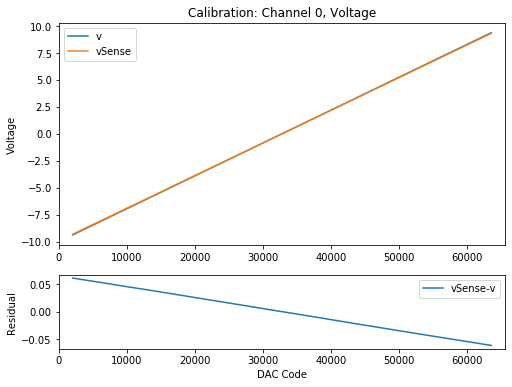

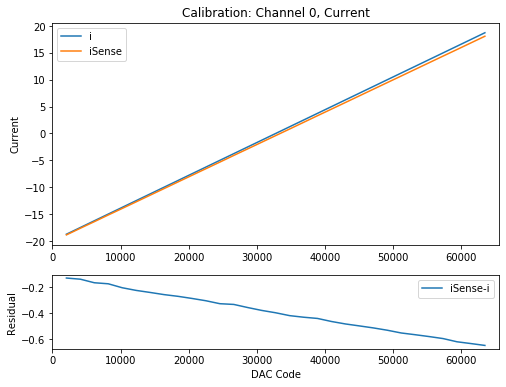

In [16]:
# have a look of the swept result
slot = 6
ch = 0
prefix = 'calibration/uncalibrated/'
v, i = plot_cal(slot, ch, prefix)

In [14]:
v

array([-9.375, -8.75 , -8.125, -7.5  , -6.875, -6.25 , -5.625, -5.   ,
       -4.375, -3.75 , -3.125, -2.5  , -1.875, -1.25 , -0.625,  0.   ,
        0.625,  1.25 ,  1.875,  2.5  ,  3.125,  3.75 ,  4.375,  5.   ,
        5.625,  6.25 ,  6.875,  7.5  ,  8.125,  8.75 ,  9.375])

In [58]:
# calculate calibration parameters and configure into the onboard eeprom
prefix = 'calibration/uncalibrated/'
for slot in range(16):
    for ch in range(8):
        if ( (occupancy[slot]&(1<<(7-ch))) ):
            print("Slot{} Ch {}".format(slot,ch))
            filename = prefix+'Slot{}_Ch{}_cal1.csv'.format(slot,ch)
            cal1 = read_csv(filename)
            x1 = cal1[:,0]
            v = (x1-32768)*102.4+8388608
            length = cal1.shape[1]
            n = len(range(2,length,2))
            vSense_avg = 0
            for idx in range(2,length,2):
                vSense_avg = vSense_avg+cal1[:,idx]
            vSense_avg = vSense_avg/n
            vSense_avg = vSense_avg/25*8388608+8388608

            x = vSense_avg.reshape((-1,1))
            reg = LinearRegression().fit(x, v)
            gain_v = int( (reg.coef_*10-9)*(1<<23) )
            offset_v = int(np.mean(v-vSense_avg*reg.coef_))+(1<<23)
            print(gain_v,offset_v)

            filename = prefix+'Slot{}_Ch{}_cal2.csv'.format(slot,ch)
            cal2 = read_csv(filename)
            x2 = cal2[:,0]
            i = (x1-32768)*102.4*2.49/2.5+8388608
            iSense_avg = 0
            for idx in range(1,length,2):
                iSense_avg = iSense_avg+cal2[:,idx]
            iSense_avg = iSense_avg/n
            iSense_avg = iSense_avg*49.8/2500*8388608+8388608

            x = iSense_avg.reshape((-1,1))
            reg = LinearRegression().fit(x, i)
            gain_i = int( (reg.coef_*10-9)*(1<<23) )
            offset_i = int(np.mean(i-iSense_avg*reg.coef_))+(1<<23)
            print(gain_i,offset_i)

            # set_calibration_params(shell, slot, ch, gain_v, offset_v, gain_i, offset_i)

Slot4 Ch 1
8943597 8333335
9299168 8282489
Slot4 Ch 2
8941257 8333570
9400381 8301818
Slot4 Ch 3
8950971 8332614
1743175 9033137
Slot4 Ch 4
8954703 8332005
9222717 8310742
Slot4 Ch 5
8940027 8333808
9524913 8304317
Slot4 Ch 6
8935279 8333963
9418151 8289683
Slot4 Ch 7
8929518 8334866
9346541 8305244


In [59]:
# perform another sweeping after calibration configuration and store the result into a different folder
nCal = 32
step = int(65536/nCal)
nRep = 3
for slot in trange(16, desc="Total"):
    for ch in trange(8, desc="Slot {}".format(slot), leave=False):
        if ( (occupancy[slot]&(1<<(7-ch))) ):
            cal1 = []
            config_channel_mode(shell, slot, ch, RANGE_10V_BIP)
            for index in trange(nCal, desc='Channel {}:Voltage'.format(ch), leave=False):
                value = index*step
                set_dac_code(shell, slot, ch, value)
                res = []
                res.append(value)
                for i in range(nRep):
                    res.append(measure(shell, slot, ch, MAX11254_CURRENT))
                    res.append(measure(shell, slot, ch, MAX11254_SENSE_VOLTAGE))
                cal1.append(res)
            cal1 = np.asarray(cal1)

            cal2 = []
            config_channel_mode(shell, slot, ch, RANGE_20mA_BIP)
            for index in trange(nCal, desc='Channel {}:Current'.format(ch), leave=False):
                value = index*step
                set_dac_code(shell, slot, ch, value)
                res = []
                res.append(value)
                for i in range(nRep):
                    res.append(measure(shell, slot, ch, MAX11254_CURRENT))
                    res.append(measure(shell, slot, ch, MAX11254_SENSE_VOLTAGE))
                cal2.append(res)
            cal2 = np.asarray(cal2)

            filename = 'calibration/calibrated/Slot{}_Ch{}_cal1.csv'.format(slot,ch)
            save_csv(cal1, filename)
            filename = 'calibration//calibrated/Slot{}_Ch{}_cal2.csv'.format(slot,ch)
            save_csv(cal2, filename)

Set Slot 7 Channel 0's mode to: 10V BIP


Set Slot 7 Channel 0's mode to: 20mA BIP


Set Slot 7 Channel 1's mode to: 10V BIP


Set Slot 7 Channel 1's mode to: 20mA BIP


Set Slot 7 Channel 2's mode to: 10V BIP


Set Slot 7 Channel 2's mode to: 20mA BIP


Set Slot 7 Channel 4's mode to: 10V BIP


Set Slot 7 Channel 4's mode to: 20mA BIP


Set Slot 7 Channel 5's mode to: 10V BIP


Set Slot 7 Channel 5's mode to: 20mA BIP


Set Slot 7 Channel 6's mode to: 10V BIP


Set Slot 7 Channel 6's mode to: 20mA BIP


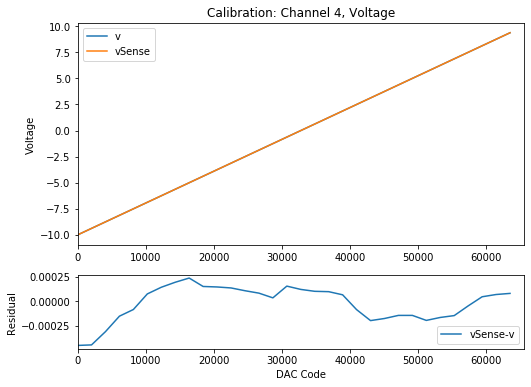

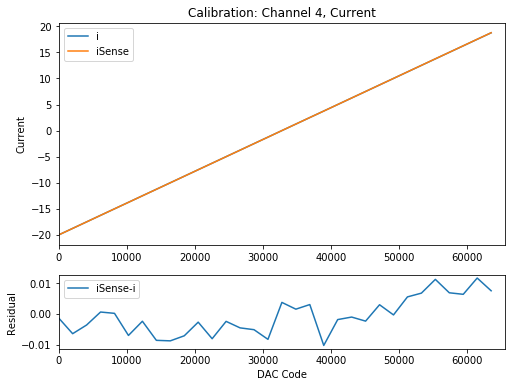

In [64]:
# have a look at the calibrated result
slot = 7
ch = 4
prefix = 'calibration/calibrated/'
plot_cal(slot, ch, prefix)

In [12]:
# close ssh connection
ssh.close() 